In [77]:
import numpy as np
import pandas as pd
from QCNN import *
from qiskit.providers.aer import AerSimulator    
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit import IBMQ
import random

In [78]:
IBMQ.save_account("5ca7d6c16097045f1eda6c3be9c710e87d1f363e5fdd0e4bf41d2113aa51f14c02f39d4f1110ac7c7569f732a62df837ee407a44d629e96da438bab3a8cb8fdc")

configrc.store_credentials:WARNING:2022-11-22 13:05:57,595: Credentials already present. Set overwrite=True to overwrite.


In [79]:
from qiskit import IBMQ

# IBMQ.save_account(TOKEN)
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q-kqc', group='internal', project='default')

ibmqfactory.load_account:WARNING:2022-11-22 13:05:58,818: Credentials are already in use. The existing account in the session will be replaced.


In [80]:
backend = AerSimulator()
# backend = provider.get_backend("ibmq_kolkata")

In [81]:
qcnn_circuit = create_full_circuit(8,qubit_encoding,conv1)

#### Encoding Methods 
- qubit_encoding
    - n차원 데이터 인코딩 기법
    - p = 8 
- dense_encoding
    - 2n차원 데이터 인코딩 기법
    - p =16
- hybrid_angle_encoding
    - (2n-2)차원 데이터 인코딩 기법
    - p = 30

#### Convolutional Filter

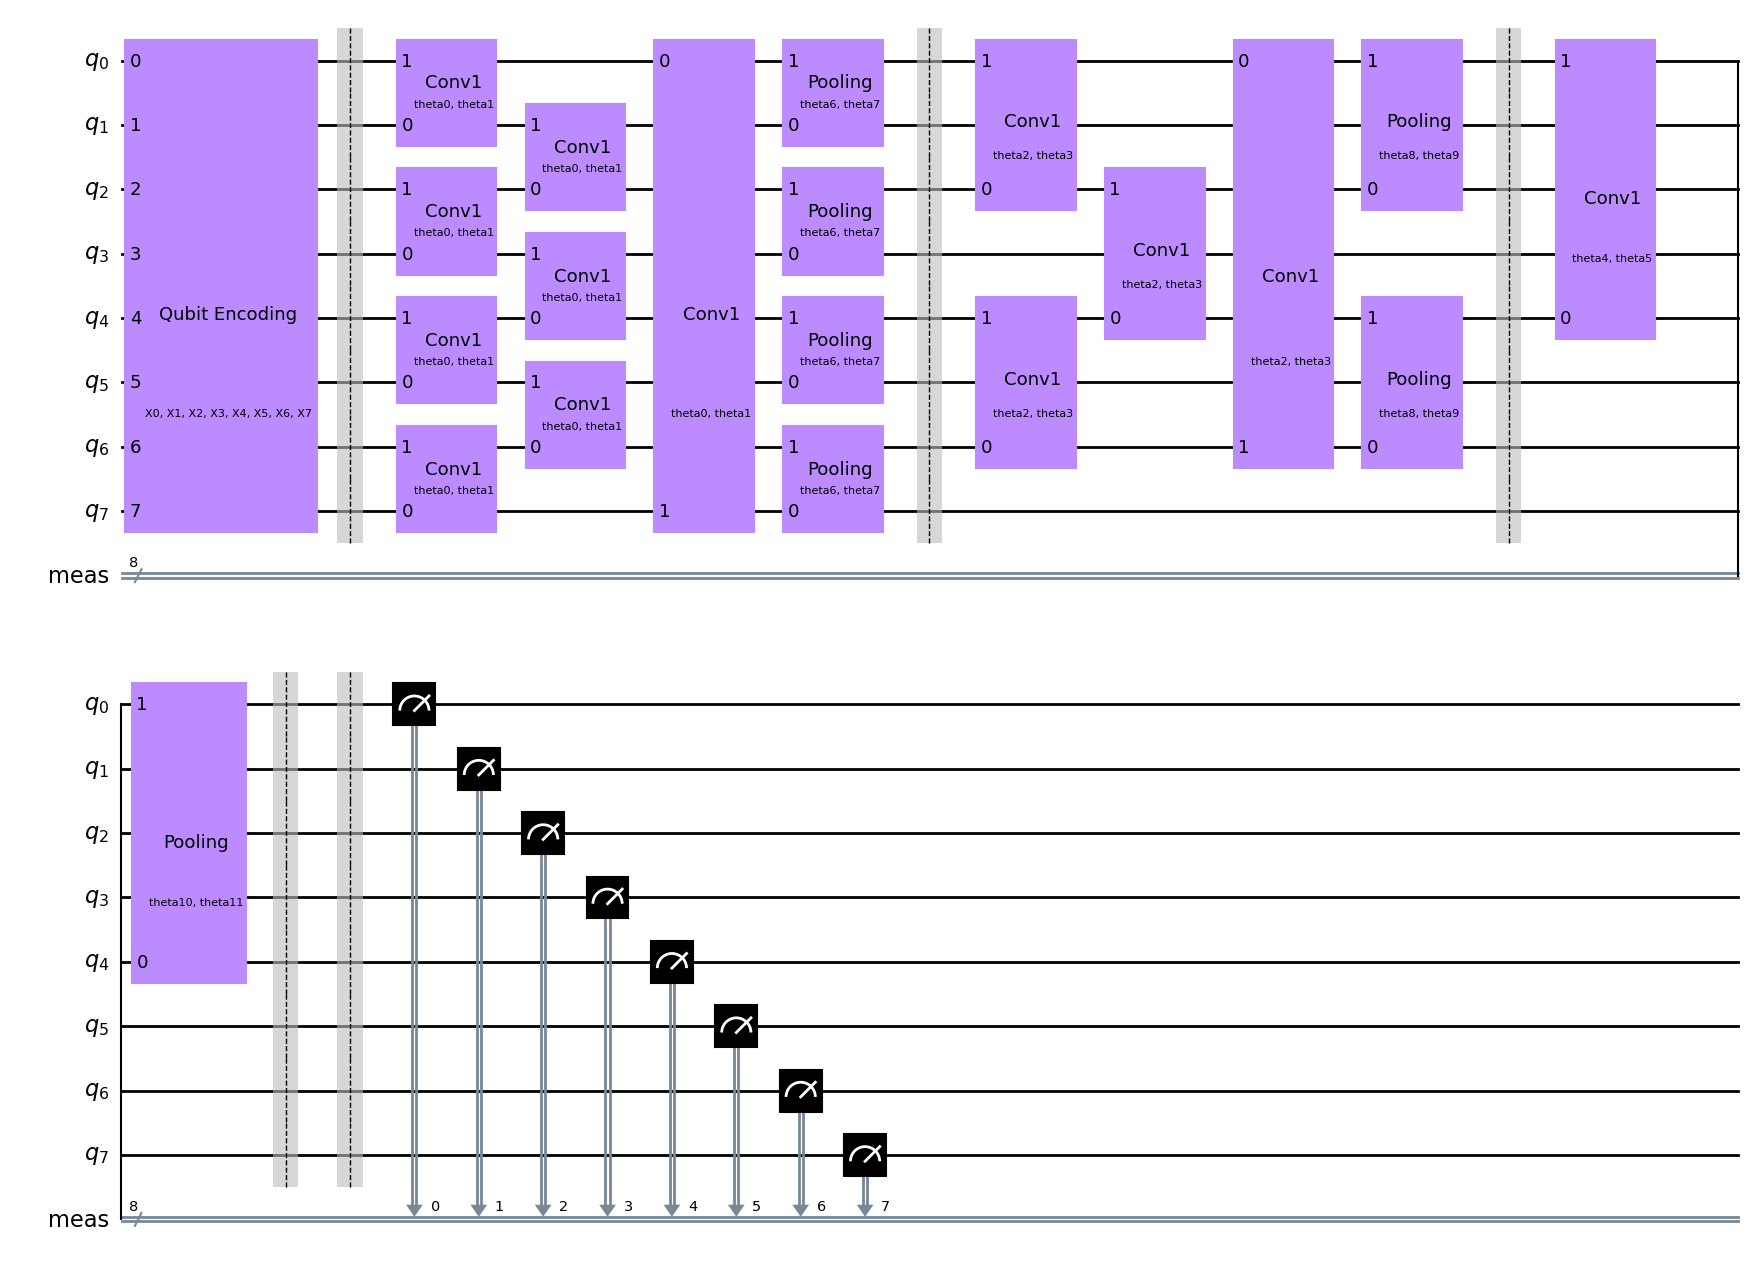

In [82]:
qcnn_circuit.draw("mpl")

In [83]:
pen_digit = pd.read_csv("pendigits.txt",header=None)
x_pen_digit = pen_digit.iloc[:5000,:16]/100
x_pen_digit_test = pen_digit.iloc[5000:,:16]/100

y_pen_digit = pen_digit.iloc[:5000,16:17]
y_pen_digit_test = pen_digit.iloc[5000:,16:17]

pca_matrix = PCA(x_pen_digit)[0]
x_pen_pca = np.matmul(x_pen_digit,pca_matrix)
x_train_pca = pi_scaler(x_pen_pca).iloc[:,:8]
x_test_pca = pi_scaler(np.matmul(x_pen_digit_test,pca_matrix)).iloc[:,:8]

sir_matrix = SIR(y_pen_digit,x_pen_digit,10)[0]
x_pen_sir = np.matmul(x_pen_digit,sir_matrix)
x_train_sir = pi_scaler(x_pen_sir).iloc[:,:8]
x_test_sir = pi_scaler(np.matmul(x_pen_digit_test,sir_matrix)).iloc[:,:8]

dr_matrix = DR(y_pen_digit,x_pen_digit,10)[0]
x_pen_dr = np.matmul(x_pen_digit,dr_matrix)
x_train_dr = pi_scaler(x_pen_dr).iloc[:,:8]
x_test_dr = pi_scaler(np.matmul(x_pen_digit_test,dr_matrix)).iloc[:,:8]

/Users/minhyeong-gyu/Desktop/QCNN/QCNN.py:291: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  eig = np.linalg.eig(np.matmul(X.T,X))
/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages

In [84]:
#(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#x_train.shape, y_train.shape, x_test.shape, y_test.shape
## 0과 1 데이터만 가져오기
#train_idx_zero_and_one = np.concatenate([np.where(y_train == 0)[0], np.where(y_train == 1)[0]])
#test_idx_zero_and_one = np.concatenate([np.where(y_test == 0)[0], np.where(y_test == 1)[0]])
#x_train = x_train[train_idx_zero_and_one]
#y_train = y_train[train_idx_zero_and_one]
#x_test = x_test[test_idx_zero_and_one]
#y_test = y_test[test_idx_zero_and_one]
#x_train.shape, y_train.shape, x_test.shape, y_test.shape
## 0과 1사이로 정규화
#x_train = x_train.astype('float32') / 255.
#x_test = x_test.astype('float32') / 255.
## 28 by 28 이미지를 768 차원으로 표현
#x_train = x_train.reshape(x_train.shape[0], -1)
#x_test = x_test.reshape(x_test.shape[0], -1)
#x_train.shape, x_test.shape

In [98]:
### 백앤드 설정
# quantum_instance = provider.get_backend('ibmq_kolkata')
# quantum_instance = provider.get_backend('ibmq_qasm_simulator')
quantum_instance = Aer.get_backend("qasm_simulator")


### 모델 및 최적화 세팅 설정
encoding_method = qubit_encoding
p=8
filter_conv = "conv1"
optimizer = COBYLA(maxiter=200)

### 저장 파일명 설정
file_name = "result/"+quantum_instance.name()+"_"+datetime.now().strftime("%d-%m-%Y %H")+"_result.csv"

### 한번에 트레인 할 샘플 개수 설정
n_samples = 25

### Pen_digit에서 어떤 숫자를 분류할지 설정
target1 = 0
target2 = 1

### 차원축소 방식 설정
x_train = x_train_pca;x_test = x_test_pca
# x_train = x_train_sir ; x_test = x_test_sir
# x_train = x_train_dr ; x_test = x_test_dr

In [99]:
# callback function that draws a live plot when the .fit() method is called
def callback(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    result.append([obj_func_eval,datetime.now().strftime("%d/%m/%Y %H:%M:%S"),*weights])
    pd.DataFrame(result).to_csv(file_name)
    plt.show()

In [100]:
target_index = (np.array(y_pen_digit == target1)+np.array(y_pen_digit == target2 )).reshape((-1,))
x_target = x_train.iloc[target_index,:]
y_target = y_pen_digit.iloc[target_index,:]
sto_index = random.sample(x_target.index.tolist(), n_samples)
x_sto = x_target.loc[sto_index,:].values
y_sto = y_target.loc[sto_index].values.reshape((-1,))

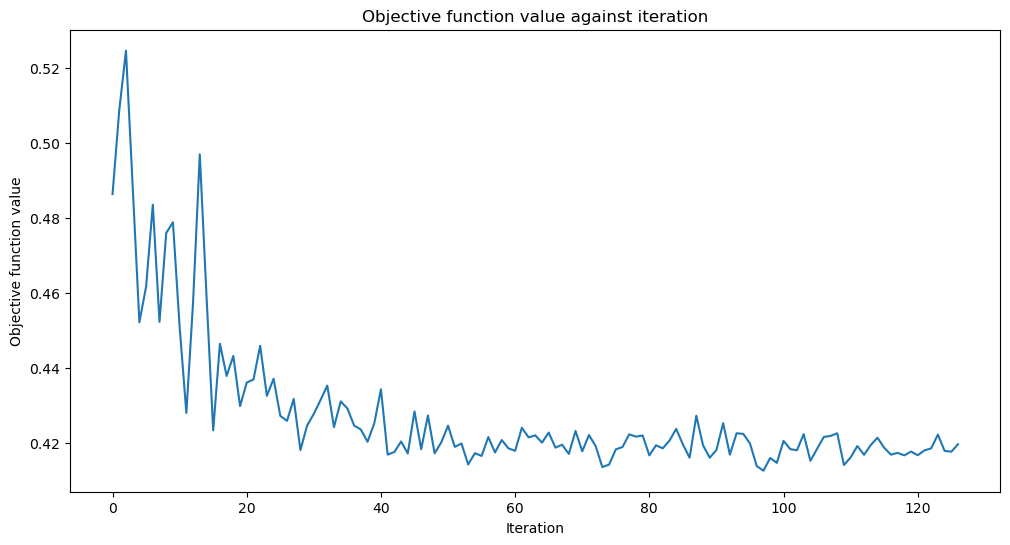

In [101]:
qc = create_full_circuit(8,encoding_method,eval(filter_conv))
circuit_qnn = CircuitQNN(circuit=qc,input_params=qc.parameters[:p],weight_params=qc.parameters[p:],
                        interpret=parity,output_shape=2,quantum_instance=quantum_instance)
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,callback=callback,optimizer=optimizer,warm_start=True)
objective_func_vals = []
result =[]
plt.rcParams["figure.figsize"] = (12, 6)
circuit_classifier.fit(x_sto, y_sto)

#### Train Score

In [103]:
circuit_classifier.score(x_sto, y_sto)

0.88

#### Test Score

In [104]:
n_samples_test = 100
target_index_test = (np.array(y_pen_digit_test == target1)+np.array(y_pen_digit_test == target2 )).reshape((-1,))
x_target_test = x_test.iloc[target_index_test,:]
y_target_test = y_pen_digit_test.iloc[target_index_test,:]
sto_index_test = random.sample(x_target_test.index.tolist(),n_samples_test)
x_sto_test = x_target_test.loc[sto_index_test,:].values
y_sto_test = y_target_test.loc[sto_index_test].values.reshape((-1,))
circuit_classifier.score(x_sto_test, y_sto_test)

0.91

#### Result Parameter

In [105]:
circuit_classifier.initial_point

array([0.47820243, 0.26204991, 0.894129  , 0.53798939, 0.89361665,
       0.25556208, 0.43969376, 0.52479944, 0.56691783, 0.34549206,
       0.68235887, 0.48236016])